In [1]:
import numpy as np 
import pandas as pd
import os
import glob
import fnmatch
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import ruptures as rpt


In [2]:
from lib.data_classes.pffpFolder import pffpDataFolder
from lib.signal_processing.signal_function import moving_average, find_deriv_change, find_drops

In [3]:
def get_change_points(signal, n_change_points= 1, model = "l1"):
    # Purpose: Use second order stationarity as a condtion to find the change points
    # Used by Hunstein et al. in https://ascelibrary.org/doi/full/10.1061/JGGEFK.GTENG-11550
    # For determining the mudline

    # Possible models are: 
    # l1: Penalizes the absolute difference between the data points and their estimated value after the change point. This model assumes that the changes are abrupt.
    # l2: Penalizes the squared difference between the data points and their estimated value after the change point. This model assumes that the changes are smooth.
    # rbf: Uses Gaussian basis functions to model the data. This model is suitable for detecting changes in periodic or oscillatory data.
    # linear: Assumes that the data follows a linear trend with abrupt changes.
    # discrete: Assumes that the data points are independent and identically distributed, with different means before and after the change point.
    # normal: Assumes that the data points are normally distributed, with different means and variances before and after the change point.
    # full: Uses a custom model defined by the user. You can specify your own cost function and penalty.

    # Apply change point detection
    algo = rpt.Dynp(model=model).fit(signal)
    result = algo.predict(n_bkps=n_change_points)  # You can specify the number of change points you want to detect

    # Zero shift the indices and return the results
    # Returns the change points and the last index
    return np.array(result)-1

In [4]:
# Testing the binary file classa
#TODO: for some reason I need the full path to read the files, I'll need to look into this in the future
# folder_dir = r"C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\test"
folder_dir = r"C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\Mouth 1"
# folder_dir = r"/home/sandbiter/Documents/BlueDrop_Analysis_Lib/Potomac_to Jonathan"
# folder_dir = r"C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\Clay_Air_Drops_GBE_AdamsPoint"
calibration_dir = r"BlueDrop_Calibration_Factors.xlsx"

In [5]:
# TODO: Combine the pffp_id and the read_calibration_excel_sheet just have the objet call inside

test_folder = pffpDataFolder(folder_dir, pffp_id = 3, calibration_factor_dir=calibration_dir)
print(test_folder)

Folder: C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\Mouth 1 
Date range: Not set 
PFFP id: 3                 
Calibration Param dir: BlueDrop_Calibration_Factors.xlsx 
Num .bin files: Not set                 
Num files with drops: Not Set


In [6]:
# Read the calibration data
test_folder.read_calibration_excel_sheet()
test_folder.calibration_excel_sheet

# Select the specific calibration params
test_folder.get_sensor_calibration_params("Sequim_2021")

# Init a pffpFile instances for each binary file and store the results in the folder
test_folder.store_pffp_files(recursive = False)

In [7]:
print(test_folder)

Folder: C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\Mouth 1 
Date range: Not set 
PFFP id: 3                 
Calibration Param dir: BlueDrop_Calibration_Factors.xlsx 
Num .bin files: 9                 
Num files with drops: Not Set


In [8]:
# Analyze the selected pffp files
test_folder.analyze_all_files(store_df=False, use_pore_pressure=True)

Folder 'C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\Mouth 1\no_drop_folder' already exists.
Folder 'C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\Mouth 1\funky' already exists.

Progress analysing drops...
[==================================================] 100.00% ETA (min): 0.09
Initial analysis complete!


In [9]:
test_folder.process_drop_files()


Progress processing drops in files...
[==================================================] 100.00% ETA (min): 0.085

In [10]:
print(test_folder.pffp_drop_files[0].drops[0])

----- Drop Info ----- 
Containing file: bLog0D2F.bin 
File Drop Index: 1 
Water Drop: None


In [11]:
print(test_folder.pffp_drop_files[3])

File Directory: C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\Mouth 1\bLog0D33.bin 
Num Drops in file: 1         
Drop Date: 2022-10-26 
Drop Time: 12:53:33         
df stored: False


File Directory: C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\Mouth 1\bLog0D37.bin 
Num Drops in file: 1         
Drop Date: 2022-10-26 
Drop Time: 12:57:33         
df stored: False


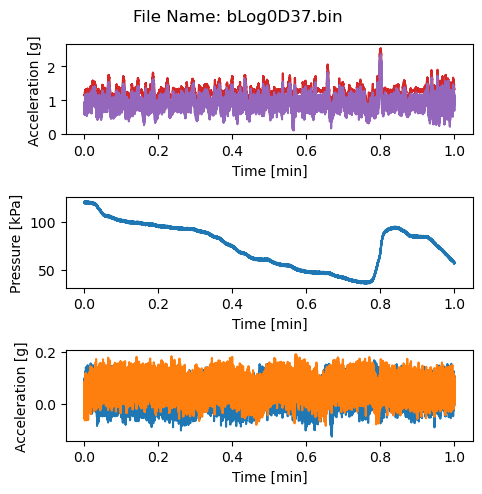

In [12]:
start = 5
end = 6
for file in test_folder.pffp_drop_files[start:end]:
    print(file)
    file.quick_view(interactive = False, figsize = [5, 5], legend = False)

# print(test_folder.pffp_funky_files[index])
# test_folder.pffp_funky_files[index].quick_view(interactive = False)


In [13]:
def parabola(x_arr, a, b, c):
    # Purpose: Return a parabola
    # a, b, c are the coeffients of the parabola
    
    return a * x_arr**2 + b * x_arr + c

In [14]:

def analyze_file_drops(accel, time, pressure, peak_index, time_tolerance = 0.01, frequency = 120_000):

    # Convert the time tolerance to a sample tolerance
    sample_tolerance = time_tolerance * frequency

    # Calc the offset from the peak 
    offset = int(sample_tolerance/2)

    # use the sample tolerance and the peak index to trim the file
    start = int(peak_index - offset)
    end = peak_index + offset

    trimmed_accel = accel[start:end]
    trimmed_time = time[start:end]
    trimmed_pressure = pressure[start:end]

    # Smooth the acceleration and the time
    window = 50
    smoothed_accel = moving_average(trimmed_accel, window)
    smoothed_time = moving_average(trimmed_time, window)
    smoothed_pressure = moving_average(trimmed_pressure, window)
    smoothed_pressure_grad = np.gradient(smoothed_pressure, smoothed_time)

    # Use the derivative cut off on the trimmed data
    indices = find_deriv_change(smoothed_time, smoothed_accel, cutoff = 1000)
    derivative = np.gradient(smoothed_accel, smoothed_time)



    x =np.linspace(-1, 1, 100)
    parabola_kernel = parabola(x, 1, 0, 1)

    # Use a convolution
    amplitude = np.max(smoothed_accel)
    kernel = np.ones(100) * amplitude
    
    # parabola_kernel *= amplitude
    convol = np.convolve(smoothed_accel-1, parabola_kernel)
    
    fig, axs  = plt.subplots(ncols = 1, nrows = 2)
    cumm_accel = np.cumsum(trimmed_accel)

    # use the statistics method
    stat_indices = get_change_points(cumm_accel, n_change_points= 1, model = "normal")
    convol_index = np.where(convol>10)[0]
    # print(convol_index)
    # Plot the acceleration data
    axs[0].plot(trimmed_time, trimmed_accel, color = "blue", label = "trimmed accel")
    axs[1].plot(convol/np.max(convol), color = "red")
    # axs[1].plot(trimmed_time, cumm_accel)
    axs[0].scatter(trimmed_time[convol_index], trimmed_accel[convol_index], color = "green")
    axs[0].axhline(y=1)
    # axs[0].scatter(smoothed_time, smoothed_accel, color = "orange", label = "smoothed data")
    # axs[1].plot(smoothed_time, derivative, color = "purple", label = "acceleration deriv")
    
    # Plot the points selected by statistics functions
    # axs[0].scatter(smoothed_time[stat_indices], smoothed_accel[stat_indices], color = "red")
    
    # Plot the derivative data
    # axs[0].scatter(smoothed_time[indices], smoothed_accel[indices], color = "red", label = "smoothed grad points")
    axs[0].scatter(time[peak_index], accel[peak_index], label = "peak")

    axs[0].legend()
    axs[1].legend()

File Directory: C:\Geotech_Research\Field_Analysis\BlueDrop_Analysis_Lib\Mouth 1\bLog0D37.bin 
Num Drops in file: 1         
Drop Date: 2022-10-26 
Drop Time: 12:57:33         
df stored: False


c:\Users\johnm\anaconda3\envs\PFFP_FieldWork\Lib\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Peak Index: 41955
<class 'numpy.int64'>


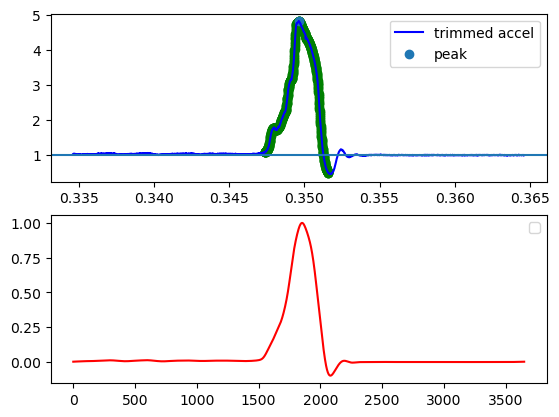

In [15]:
index = 1
print(file)
file =test_folder.pffp_drop_files[index] 
df = file.binary_2_sensor_df()

accel_18g = np.array(df["18g_accel"])
time = np.array(df["Time"])
pressure = np.array(df["pore_pressure"])

drop = file.drops[0]
peak_index = drop.peak_index
print("Peak Index: {}".format(peak_index))
# test_folder.pffp_drop_files[0].quick_view(interactive = True)
print(type(peak_index))

analyze_file_drops(accel_18g, time, pressure, peak_index, time_tolerance=0.03)


In [16]:
drop.cut_accel_data(accel_18g, time)
drop.integrate_accel_data()
release_index = 36034


In [17]:
drop.drop_indices

{'release_index': 34888,
 'start_impulse_index': 41686,
 'end_impulse_index': 42150}

KeyError: 0

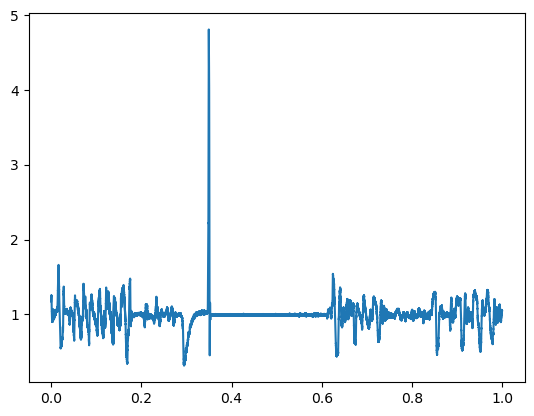

In [18]:
plt.plot(time, accel_18g)
index = drop.drop_indices[0]
plt.scatter(time[index], accel_18g[index], color = "red", s=10)
plt.xlim([0.25, 0.40])

0.11162963431895694
0      0.000000e+00
1      0.000000e+00
2      1.106645e-09
3      2.953213e-09
4      5.538787e-09
           ...     
459    1.819967e-04
460    1.829242e-04
461    1.838526e-04
462    1.847818e-04
463    1.857117e-04
Name: displacement, Length: 464, dtype: float64


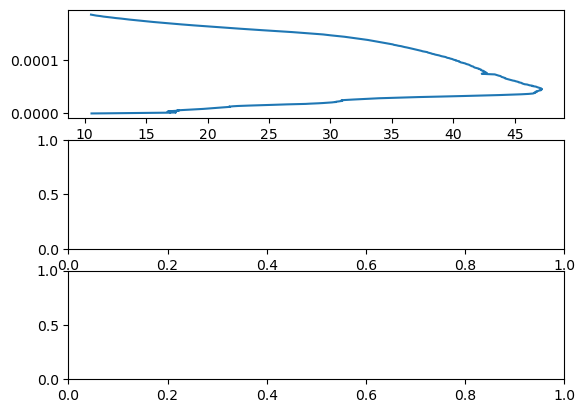

In [ ]:
fig, axs = plt.subplots(ncols = 1, nrows = 3)
df = drop.impulse_df

print(max(df["velocity"]))
print(df["displacement"])
axs[0].plot(df["accel"], df["displacement"])

In [ ]:
drop.convert_accel_units(1, "g", "m/s^2")

9.80665

In [ ]:
# file.quick_view(interactive=True)

In [ ]:
# pressure = np.array(df["pore_pressure"])

# window = 2500
# smoothed_pressure = moving_average(pressure, window)
# smoothed_time = moving_average(time, window)

# smoothed_acceleration = moving_average(accel_18g, window)
# smoothed_time = moving_average(time, window)

# accel_grad = np.gradient(smoothed_acceleration, smoothed_time)


# fig, axs = plt.subplots(ncols=1, nrows=3)

# axs[0].plot(time, accel_18g, label="18g accel")
# axs[1].plot(smoothed_time, accel_grad)
# # axs[1].plot(time, pressure, color = "red", label = "og")
# # axs[1].plot(smoothed_time, smoothed_pressure, label = "smoothed")

# smoothed_pressure_grad = np.gradient(smoothed_pressure, smoothed_time)

# stat_indices = get_change_points(smoothed_acceleration, n_change_points= 1, model = "l2")
# axs[0].scatter(smoothed_time[stat_indices], smoothed_acceleration[stat_indices], color = "red")
# axs[2].plot(smoothed_time, smoothed_pressure_grad,label = "pressure grad")

# axs[0].legend()
# axs[1].legend()
# axs[2].legend()

# plt.show()

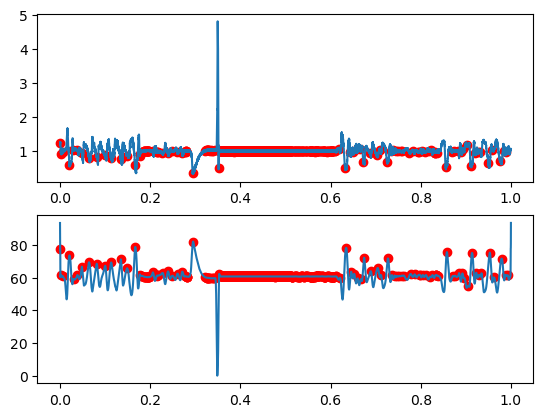

In [ ]:
fig, axs = plt.subplots(ncols = 1, nrows = 2)

axs[0].plot(time, accel_18g)

window = 500
smoothed_pressure = moving_average(pressure, window)
smoothed_time = moving_average(time, window)

smoothed_acceleration = moving_average(accel_18g, window)
smoothed_time = moving_average(time, window)


accel_grad = np.gradient(smoothed_acceleration, smoothed_time)
index = np.where(accel_grad < -40)


# axs[1].plot(smoothed_time, accel_grad )

# # Find where the gradient is negative
# axs[1].plot(smoothed_time[index], accel_grad[index], color = "red")
max_accel =np.where(accel_18g == np.max(accel_18g))
x = np.linspace(-1, 1, 100)
convol = np.convolve(smoothed_acceleration, parabola(x, -1, 0, 0))
convol = convol + np.abs(np.min(convol))

from scipy.signal import find_peaks
index, _ = find_peaks(convol, height = 35)
axs[0].scatter(time[index], accel_18g[index], color = "red")

convol_time = np.linspace(0,1, len(convol))
axs[1].plot(convol_time, convol)
axs[1].scatter(convol_time[index], convol[index], color = "red")


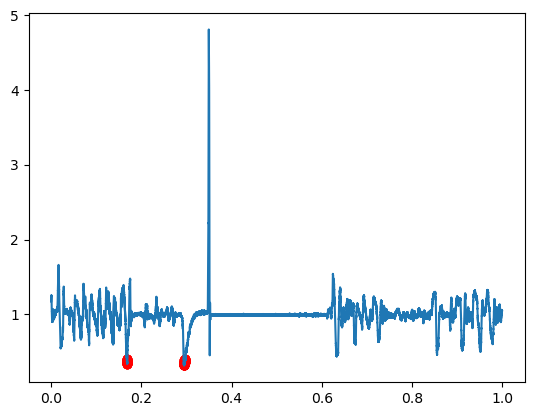

In [ ]:
test_accel = -1 * (accel_18g - 1) # Apply the assumed offset 


# Find the small peaks

index,_ = find_peaks(test_accel, height = 0.6)

plt.plot(time, accel_18g)
plt.scatter(time[index], accel_18g[index], color = "red")

In [ ]:
# Steps 

# Use the peak acceleration location to find where the minimum acceleration happened most closely
# use find_peaks to get where the acceleration is minimized
# Run back in the indices where the data reaches 1g again

In [ ]:
# release_index = release_index+1000
end_index += 1000

NameError: name 'end_index' is not defined

[43.44886207 43.44936208 43.44986208 ... 46.46838724 46.46888724
 46.46938724]
[ 0.         -0.06088857 -0.01451727 ...  0.45183516  0.50762468
  0.48692857]
6042
6041 None


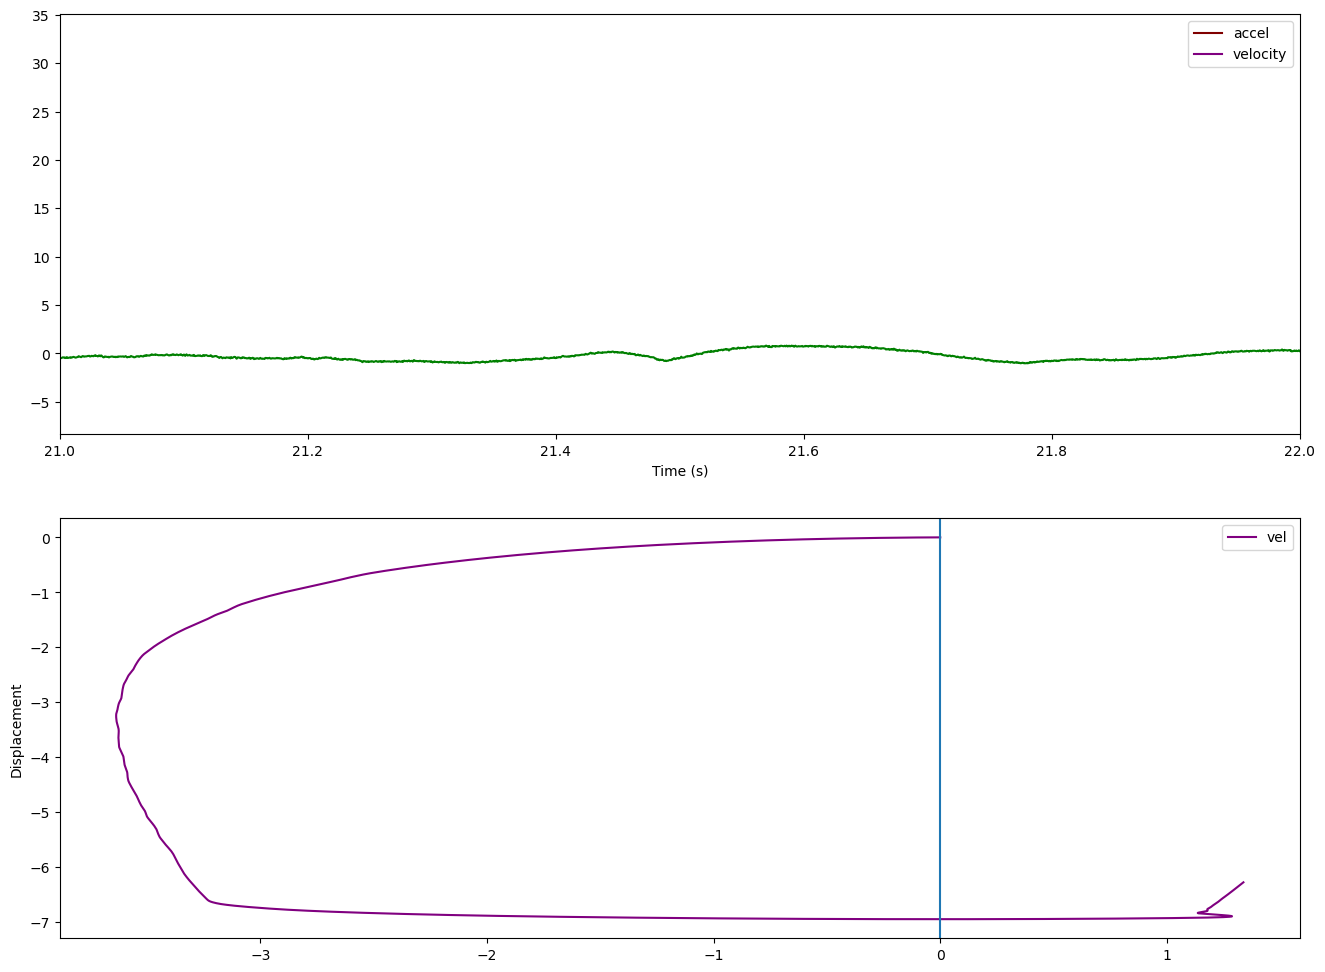

In [ ]:
from scipy.integrate import cumulative_trapezoid 

def integrate(x, y):
    # Purpose: Integrate a function. Add other integration schemee later on it wanted

    # Using trapezoidal integration for now
    return cumulative_trapezoid (y, x)
# release_index += 1000
# end_index = end_index + 10000
cut_time = time[release_index:end_index] * 60
print(cut_time)

cut_accel = (accel_18g[release_index:end_index] - accel_18g[release_index]) * 9.81
print(cut_accel)

vel = integrate(cut_time, cut_accel)
print(len(vel), print(len(cut_time)))

displacement =integrate(cut_time[1:], vel)


fig, axs = plt.subplots(ncols = 1, nrows = 2, figsize = (16, 12))
# Time plots
axs[0].plot(time*60, (accel_18g-1)*9.81, color = "green")
axs[0].plot(cut_time, cut_accel, label = "accel", color = "maroon")
axs[0].plot(cut_time[1:], vel, label = "velocity", color = "purple")

# axs[1].plot(cut_accel[2:], displacement, label = "accel")
axs[1].plot(vel[1:], displacement, label = "vel", color = "purple")

# Time plot
axs[0].set_xlabel("Time (s)")
# axs[0].axhline(y = 0)
# axs[0].ylabel("Velocity")
axs[0].legend()
axs[0].set_xlim(21, 22)
# Displacement plot
axs[1].set_ylabel("Displacement")
axs[1].axvline(x = 0)
axs[1].legend()
